<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/lstm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd





In [3]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200
True
{'login': 213644473, 'trade_mode': 0, 'leverage': 1000, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 200.0, 'credit': 0.0, 'profit': 0.0, 'equity': 200.0, 'margin': 0.0, 'margin_free': 200.0, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'micheal bright omage ', 'server': 'OctaFX-Demo', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': True, 'build': 5370, 'maxbars': 100000000, 'codepage': 0, 'ping_last

In [4]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True or terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

200.0
AI is successfully functional


In [5]:
symbols = mt5.symbols_get()
print(len(symbols))
t_symbol = []
for symbol in symbols:
    if "USD" in symbol.name:
        print("Yes ", symbol.name)
        t_symbol.append(symbol.name)

print(len(t_symbol))

280
Yes  EURUSD
Yes  GBPUSD
Yes  USDJPY
Yes  USDCHF
Yes  AUDUSD
Yes  NZDUSD
Yes  USDCAD
Yes  USDMXN
Yes  USDZAR
Yes  XAGUSD
Yes  XAUUSD
Yes  XBRUSD
Yes  XTIUSD
Yes  XNGUSD
Yes  BTCUSD
Yes  ETHUSD
Yes  LTCUSD
Yes  XRPUSD
Yes  BCHUSD
Yes  AAVEUSD
Yes  ADAUSD
Yes  ALGOUSD
Yes  ATOMUSD
Yes  AVAXUSD
Yes  AXSUSD
Yes  BNBUSD
Yes  DASHUSD
Yes  DOGEUSD
Yes  DOTUSD
Yes  FILUSD
Yes  GRTUSD
Yes  ICPUSD
Yes  IOTAUSD
Yes  LINKUSD
Yes  LRCUSD
Yes  MANAUSD
Yes  NEARUSD
Yes  SOLUSD
Yes  UNIUSD
Yes  ZECUSD
Yes  ETCUSD
Yes  TRXUSD
Yes  FETUSD
Yes  ARBUSD
Yes  APTUSD
Yes  SUIUSD
Yes  USDDKK
Yes  USDCZK
Yes  USDHUF
Yes  USDNOK
Yes  USDPLN
Yes  USDSEK
Yes  USDSGD
Yes  USDHKD
Yes  USDCNH
Yes  USDTRY
Yes  XBRUSD.Daily
Yes  XTIUSD.Daily
Yes  BTCUSD.Daily
Yes  ETHUSD.Daily
Yes  XRPUSD.Daily
Yes  LTCUSD.Daily
Yes  BCHUSD.Daily
Yes  LINKUSD.Daily
Yes  SOLUSD.Daily
65


In [28]:
t_s = "BTCUSD"
market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_M5, 0, 10000000)
display(market)
print(market.shape)

print(t_s)


data = []
for i in range(len(market)):
    data.append([market[i][1],market[i][2],market[i][3],market[i][4],market[i][5]])
df = pd.DataFrame(data, columns=["open", "high","low", "close", "volume"])
df.to_csv("Generated"+t_s+" dbot.csv", index=False)

array([(1311242400, 1.3690000e+01, 1.3780000e+01, 1.3400000e+01, 1.3610000e+01,   69,    0, 0),
       (1311328800, 1.3610000e+01, 1.3810000e+01, 1.3450000e+01, 1.3700000e+01,   64,    0, 0),
       (1311415200, 1.3700000e+01, 1.3760000e+01, 1.3510000e+01, 1.3680000e+01,   49,    0, 0),
       ...,
       (1760819100, 1.0678301e+05, 1.0696346e+05, 1.0676581e+05, 1.0693836e+05, 1293, 2250, 0),
       (1760819400, 1.0693651e+05, 1.0697401e+05, 1.0681261e+05, 1.0685496e+05, 1250, 2252, 0),
       (1760819700, 1.0685331e+05, 1.0688001e+05, 1.0683882e+05, 1.0686067e+05,  556, 2252, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

(719038,)
BTCUSD


In [6]:
import joblib

joblib.dump(t_symbol,"symbol.joblib")

['symbol.joblib']

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print(tf.__version__)


2.10.1


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scaler3d2d import preprocess_and_save_scalers,transform_data, inverse_transform_data,create_sequences



In [3]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import keras

In [4]:
# Get the list of all files and directories in the specified path

dir_contents = os.listdir(".")
t_symbol = joblib.load("symbol.joblib")

In [5]:
print(t_symbol)

['EURUSD', 'GBPUSD', 'USDJPY', 'USDCHF', 'AUDUSD', 'NZDUSD', 'USDCAD', 'USDMXN', 'USDZAR', 'XAGUSD', 'XAUUSD', 'XBRUSD', 'XTIUSD', 'XNGUSD', 'BTCUSD', 'ETHUSD', 'LTCUSD', 'XRPUSD', 'BCHUSD', 'AAVEUSD', 'ADAUSD', 'ALGOUSD', 'ATOMUSD', 'AVAXUSD', 'AXSUSD', 'BNBUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'FILUSD', 'GRTUSD', 'ICPUSD', 'IOTAUSD', 'LINKUSD', 'LRCUSD', 'MANAUSD', 'NEARUSD', 'SOLUSD', 'UNIUSD', 'ZECUSD', 'ETCUSD', 'TRXUSD', 'FETUSD', 'ARBUSD', 'APTUSD', 'SUIUSD', 'USDDKK', 'USDCZK', 'USDHUF', 'USDNOK', 'USDPLN', 'USDSEK', 'USDSGD', 'USDHKD', 'USDCNH', 'USDTRY', 'XBRUSD.Daily', 'XTIUSD.Daily', 'BTCUSD.Daily', 'ETHUSD.Daily', 'XRPUSD.Daily', 'LTCUSD.Daily', 'BCHUSD.Daily', 'LINKUSD.Daily', 'SOLUSD.Daily']


In [6]:
t_symbol = ["BTCUSD"]

In [7]:

# Filter the list to include only files, not directories
# os.path.join is used to create a full path for isfile() to check
files = [item for item in dir_contents]

file_target = []
test_target = []

for filename in files:
    for t_s in t_symbol:
        if t_s in filename  and "dbot.csv" in filename:
            print(filename)
            file_target.append(filename)
            test_target.append(filename.replace("dbot","test"))

print("----------------------------------------------------")

print(len(file_target))
print(len(test_target))
train_dfs = []
for f_t in file_target:
    train_dfs.append(pd.read_csv(f_t))
try:
    train_dfs_test = []
    for f_t in test_target:
        train_dfs_test.append(pd.read_csv(f_t))
except:
    pass

GeneratedBTCUSD dbot.csv
----------------------------------------------------
1
1


In [8]:

import ta  # Technical Analysis library

def engineer_features_5min_btc(df):
    """
    Input: df with columns ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    Output: df with 68 features
    """
    
    # GROUP 1: Core Price Features
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
    df['weighted_close'] = (df['high'] + df['low'] + 2*df['close']) / 4
    df['hl_range'] = df['high'] - df['low']
    df['body_size'] = abs(df['close'] - df['open'])
    df['upper_wick'] = df['high'] - df[['open', 'close']].max(axis=1)
    df['lower_wick'] = df[['open', 'close']].min(axis=1) - df['low']
    
    # GROUP 2: Volume Features
    df['volume_usd'] = df['volume'] * df['close']
    df['volume_ma10'] = df['volume'].rolling(10).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma10']
    df['volume_delta'] = df['volume'].diff()
    df['vwap'] = (df['typical_price'] * df['volume']).cumsum() / df['volume'].cumsum()
    df['distance_to_vwap'] = (df['close'] - df['vwap']) / df['close']
    df['obv'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    
    # GROUP 3: Price Momentum
    df['price_change'] = df['close'].diff()
    df['price_change_pct'] = df['close'].pct_change() * 100
    df['price_change_5'] = df['close'].diff(5)
    df['price_change_12'] = df['close'].diff(12)
    df['roc_10'] = ((df['close'] - df['close'].shift(10)) / df['close'].shift(10)) * 100
    df['roc_20'] = ((df['close'] - df['close'].shift(20)) / df['close'].shift(20)) * 100
    df['momentum_10'] = df['close'] - df['close'].shift(10)
    
    # RSI
    df['rsi_14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['rsi_7'] = ta.momentum.RSIIndicator(df['close'], window=7).rsi()
    
    # Stochastic
    stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'], 
                                             window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()
    
    # Williams %R
    df['williams_r'] = ta.momentum.WilliamsRIndicator(df['high'], df['low'], df['close'], 
                                                       lbp=14).williams_r()
    
    # GROUP 4: Trend Features
    df['sma_10'] = df['close'].rolling(10).mean()
    df['sma_20'] = df['close'].rolling(20).mean()
    df['sma_50'] = df['close'].rolling(50).mean()
    df['ema_9'] = df['close'].ewm(span=9, adjust=False).mean()
    df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()
    df['distance_to_sma10'] = (df['close'] - df['sma_10']) / df['close']
    df['distance_to_sma50'] = (df['close'] - df['sma_50']) / df['close']
    df['sma10_slope'] = df['sma_10'].diff(5)
    df['sma50_slope'] = df['sma_50'].diff(5)
    
    # ADX
    adx = ta.trend.ADXIndicator(df['high'], df['low'], df['close'], window=14)
    df['adx_14'] = adx.adx()
    df['plus_di'] = adx.adx_pos()
    df['minus_di'] = adx.adx_neg()
    
    # GROUP 5: Volatility Features
    df['atr_14'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], 
                                                   window=14).average_true_range()
    df['atr_normalized'] = df['atr_14'] / df['close']
    
    # Bollinger Bands
    bb = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
    df['bb_upper'] = bb.bollinger_hband()
    df['bb_lower'] = bb.bollinger_lband()
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['sma_20']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    df['stddev_20'] = df['close'].pct_change().rolling(20).std()
    df['historical_vol'] = df['close'].pct_change().rolling(20).std() * np.sqrt(288)  # 288 5-min periods in a day
    
    # GROUP 6: MACD Features
    macd = ta.trend.MACD(df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['macd_line'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_histogram'] = macd.macd_diff()
    

    
    # GROUP 7: Support/Resistance Features
    df['recent_high_20'] = df['high'].rolling(20).max()
    df['recent_low_20'] = df['low'].rolling(20).min()
    df['distance_to_high'] = (df['recent_high_20'] - df['close']) / df['close']
    df['distance_to_low'] = (df['close'] - df['recent_low_20']) / df['close']
    df['pivot_point'] = (df['high'].shift(1) + df['low'].shift(1) + df['close'].shift(1)) / 3
    df['range_position'] = (df['close'] - df['low']) / (df['high'] - df['low'])
    
    return df

# Usage:
# df = pd.read_csv('btcusd_5min.csv')
# df = engineer_features_5min_btc(df)

In [9]:
n = 0
m_label = file_target[n].replace("dbot.csv","")
train_df = train_dfs[n]
train_df = engineer_features_5min_btc(train_df)[200:]

In [10]:
display(train_df)

,open,high,low,close,volume,typical_price,weighted_close,hl_range,body_size,upper_wick,...,historical_vol,macd_line,macd_signal,macd_histogram,recent_high_20,recent_low_20,distance_to_high,distance_to_low,pivot_point,range_position
200,5.60,5.92,5.50,5.83,62,5.750000,5.7700,0.42,0.23,0.09,...,0.787835,0.000637,0.040796,-0.040159,6.55,5.05,0.123499,0.133791,5.583333,0.785714
201,5.83,5.99,5.80,5.91,31,5.900000,5.9025,0.19,0.08,0.08,...,0.770822,0.013537,0.035344,-0.021807,6.45,5.05,0.091371,0.145516,5.750000,0.578947
202,5.91,6.00,5.54,5.60,62,5.713333,5.6850,0.46,0.31,0.09,...,0.788839,-0.001239,0.028027,-0.029267,6.39,5.05,0.141071,0.098214,5.900000,0.130435
203,5.60,5.85,5.43,5.51,76,5.596667,5.5750,0.42,0.09,0.25,...,0.788166,-0.019982,0.018426,-0.038407,6.39,5.05,0.159710,0.083485,5.713333,0.190476
204,5.51,5.72,5.20,5.26,80,5.393333,5.3600,0.52,0.25,0.21,...,0.802053,-0.054382,0.003864,-0.058246,6.32,5.05,0.201521,0.039924,5.596667,0.115385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719033,106723.29,106806.71,106714.88,106762.63,730,106761.406667,106761.7125,91.83,39.34,44.08,...,0.012526,-78.687321,-81.674173,2.986852,107091.38,106477.18,0.003079,0.002674,106688.386667,0.519983
719034,106761.08,106787.62,106728.97,106783.06,917,106766.550000,106770.6775,58.65,21.98,4.56,...,0.012555,-68.520832,-79.043505,10.522672,107091.38,106477.18,0.002887,0.002864,106761.406667,0.922251
719035,106783.01,106963.46,106765.81,106938.36,1293,106889.210000,106901.4975,197.65,155.35,25.10,...,0.013780,-47.386167,-72.712037,25.325871,107091.38,106477.18,0.001431,0.004313,106766.550000,0.873008
719036,106936.51,106974.01,106812.61,106854.96,1250,106880.526667,106874.1350,161.40,81.55,37.50,...,0.013972,-36.940646,-65.557759,28.617113,107091.38,106477.18,0.002213,0.003535,106889.210000,0.262392


In [11]:

#train_df_test = train_dfs_test[n]
print(m_label)
SEQ_LEN = 90 # length of input sequence (timesteps). Typical choices: 30, 60, 90
n_rows, n_features = train_df.values.shape

X, y = create_sequences(train_df.values, SEQ_LEN, 1, 3)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)
#X1, y1 = create_sequences(train_df.values, SEQ_LEN, 5)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)

n_samples = X.shape[0]
print(X[-1])
print(y[-1])

GeneratedBTCUSD 
[[1.06909880e+05 1.06967830e+05 1.06899240e+05 ... 2.72855429e-03
  1.06916217e+05 6.39160227e-01]
 [1.06943230e+05 1.06965020e+05 1.06892990e+05 ... 2.65279719e-03
  1.06936717e+05 7.04289879e-01]
 [1.06943170e+05 1.06943170e+05 1.06834170e+05 ... 2.36538319e-03
  1.06933910e+05 7.22385321e-01]
 ...
 [1.06761080e+05 1.06787620e+05 1.06728970e+05 ... 2.86449929e-03
  1.06761407e+05 9.22250639e-01]
 [1.06783010e+05 1.06963460e+05 1.06765810e+05 ... 4.31257783e-03
  1.06766550e+05 8.73007842e-01]
 [1.06936510e+05 1.06974010e+05 1.06812610e+05 ... 3.53544655e-03
  1.06889210e+05 2.62391574e-01]]
[106860.67]


In [12]:
print(X[-1])

[[1.06909880e+05 1.06967830e+05 1.06899240e+05 ... 2.72855429e-03
  1.06916217e+05 6.39160227e-01]
 [1.06943230e+05 1.06965020e+05 1.06892990e+05 ... 2.65279719e-03
  1.06936717e+05 7.04289879e-01]
 [1.06943170e+05 1.06943170e+05 1.06834170e+05 ... 2.36538319e-03
  1.06933910e+05 7.22385321e-01]
 ...
 [1.06761080e+05 1.06787620e+05 1.06728970e+05 ... 2.86449929e-03
  1.06761407e+05 9.22250639e-01]
 [1.06783010e+05 1.06963460e+05 1.06765810e+05 ... 4.31257783e-03
  1.06766550e+05 8.73007842e-01]
 [1.06936510e+05 1.06974010e+05 1.06812610e+05 ... 3.53544655e-03
  1.06889210e+05 2.62391574e-01]]


In [13]:
X, y = preprocess_and_save_scalers(X, y)


Scaler for X saved to 'scaler_x.joblib'
Scaler for Y saved to 'scaler_y.joblib'


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=False)
X_val, X_test, y_val,  y_test = train_test_split(X_test, y_test, test_size=0.01, random_state=0, shuffle=False)

seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))
X = Bidirectional(LSTM(128, return_sequences=True))(i)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)

X = Bidirectional(LSTM(64, return_sequences=True))(X)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)


X = LSTM(32)(X)
X = Dropout(0.25)(X)

X = Dense(16, activation="relu")(X)
X = Dropout(0.25)(X)
X = Dense(8, activation="relu")(X)
X = Dense(output_dim)(X)

model = Model(i, X)
model.summary()


In [ ]:

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),'mape','msle'])
r = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  #batch_size=64,
  callbacks=[es, rlr, mc ],
  verbose=1

)




Epoch 1/100
1/2 [==============>...............] - ETA: 5s - loss: 0.5734 - mae: 0.7337 - root_mean_squared_error: 0.7572 - mape: 115.9365 - msle: 0.2404
Epoch 1: val_loss improved from inf to 0.19960, saving model to GeneratedBTCUSD lstm_best.keras
2/2 [==============================] - 7s 1s/step - loss: 0.5068 - mae: 0.6823 - root_mean_squared_error: 0.7119 - mape: 105.9648 - msle: 0.2297 - val_loss: 0.1996 - val_mae: 0.3937 - val_root_mean_squared_error: 0.4468 - val_mape: 67041.2031 - val_msle: 0.1176 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.2708 - mae: 0.4877 - root_mean_squared_error: 0.5204 - mape: 74.8812 - msle: 0.1431
Epoch 2: val_loss improved from 0.19960 to 0.18162, saving model to GeneratedBTCUSD lstm_best.keras
2/2 [==============================] - 0s 204ms/step - loss: 0.2708 - mae: 0.4877 - root_mean_squared_error: 0.5204 - mape: 74.8812 - msle: 0.1431 - val_loss: 0.1816 - val_mae: 0.3750 - val_root_mean_squared_error: 0.4262 

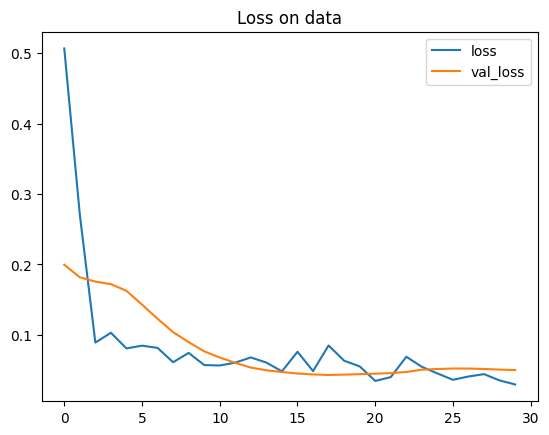

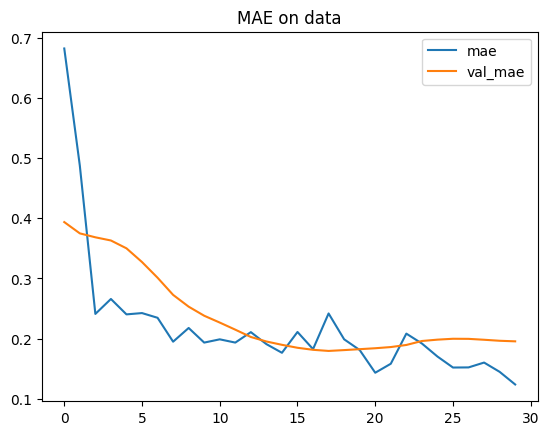

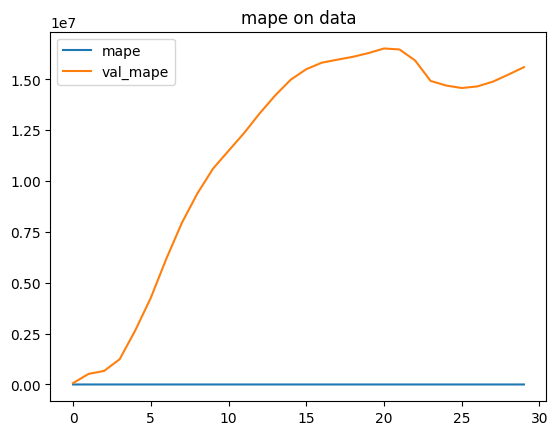

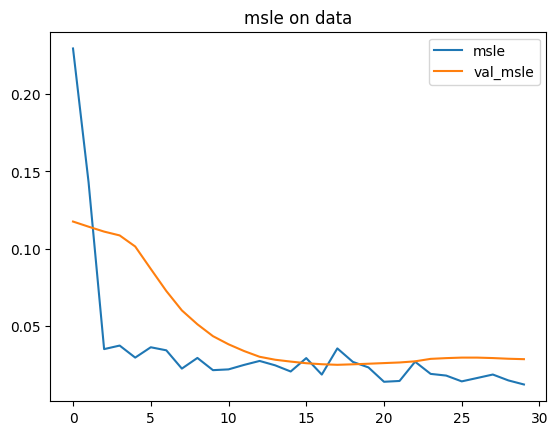

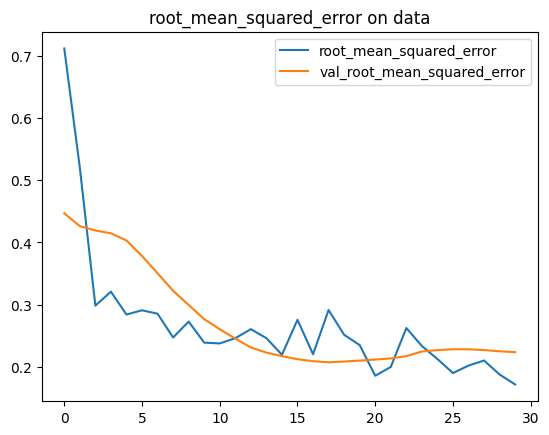

In [ ]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

plt.title("mape on data")
plt.plot(r.history['mape'], label="mape")
plt.plot(r.history['val_mape'], label="val_mape")
plt.legend()
plt.show()

plt.title("msle on data")
plt.plot(r.history['msle'], label="msle")
plt.plot(r.history['val_msle'], label="val_msle")
plt.legend()
plt.show()

plt.title("root_mean_squared_error on data")
plt.plot(r.history['root_mean_squared_error'], label="root_mean_squared_error")
plt.plot(r.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
plt.legend()
plt.show()




In [ ]:
best_model = load_model(m_label + 'lstm_best.keras')


In [ ]:
y_pred = best_model.predict(X_test)

1/1 [==============================] - 1s 935ms/step


In [ ]:
print(y_pred.shape)

(1, 1)


In [ ]:
_,y_test = inverse_transform_data(scaled_y=y_test)
_,y_pred = inverse_transform_data(scaled_y=y_pred)
print(y_test, " comparing to ", y_pred)

[[106860.67]]  comparing to  [[106640.52]]


In [ ]:
# 1. Calculate the error (the gap between actual and predicted)
error = y_test - y_pred

# 2. Calculate the average gap (the bias)
average_gap = np.mean(error)
print(f"Average Gap (Bias): {average_gap:.7f}")

# 3. Add the average gap to your predictions to create a corrected version
y_pred_corrected = y_pred + average_gap

# --- Verification ---
# Let's check the first predicted value vs. the first actual value
print("\n--- Example of Correction ---")
print(f"Original Prediction: {y_pred[0, 0]:.7f}")
print(f"Corrected Prediction: {y_pred_corrected[0, 0]:.7f}")
print(f"Actual Value:        {y_test[0, 0]:.7f}")

Average Gap (Bias): 220.1465625

--- Example of Correction ---
Original Prediction: 106640.5234375
Corrected Prediction: 106860.6718750
Actual Value:        106860.6700000


In [ ]:
print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred))

R^2 value for  GeneratedBTCUSD 
nan


c:\Users\omage\.conda\envs\py310\lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


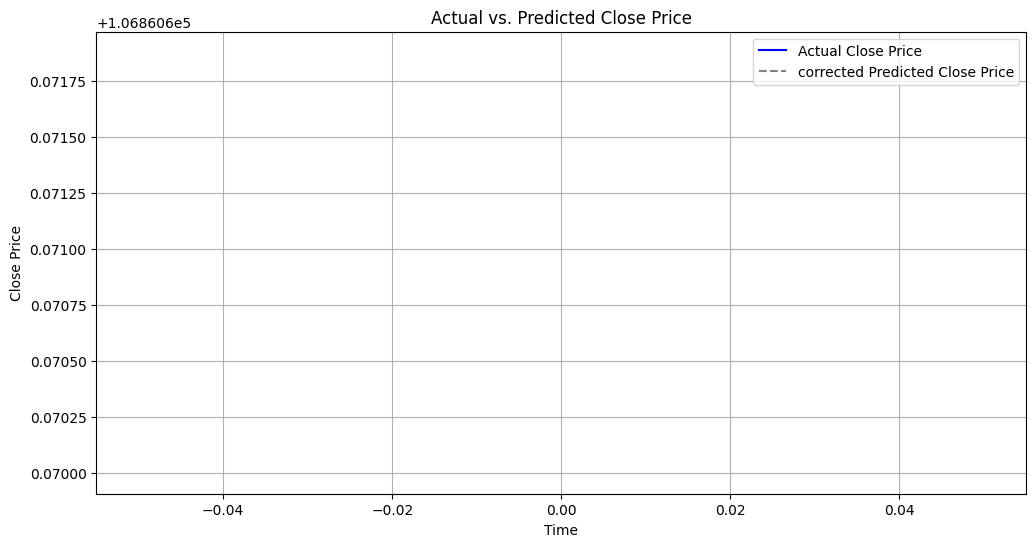

In [ ]:




plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Actual Close Price', color='blue')
#plt.plot(y_pred[:, 0], label='Predicted Close Price', color='red', linestyle='--')
plt.plot(y_pred_corrected[:, 0], label='corrected Predicted Close Price', color='gray', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()
